##  Toronto Neighborhoods Segmenting and Clustering  

#### *Author: Mohammad Sayeb*

#### Let's import the relevant modules

In [11]:
import numpy as np #for dealing with multidimensional arrays and matrices
import pandas as pd #pandas data frame from efficient dataframe manipulation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
import geocoder # convert an address into latitude and longitude values
!pip3 install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests #requesting information from webpages 
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import plotly #visualization tool

# Matplotlib and associated plotting modules
import matplotlib 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

#tools for scrapping website for data
import bs4 #beautiful soup library for website scraping 
from bs4 import BeautifulSoup #scraping tool
import lxml #needed to convert html bs4 object to data frame
from tqdm import tqdm

Defaulting to user installation because normal site-packages is not writeable


## Section 1

We scrape table data from the wiki page and assign it to a DataFrame table

In [4]:
URL='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')
table = soup.find_all('table')

In [5]:
len(table)

3

In [6]:
df = pd.read_html(str(table))[0]
df.shape

(180, 3)

Ignore the rows that don't have an assigned borough

In [7]:
df = df[df['Borough']!='Not assigned']
print (df.shape)
df.head()

(103, 3)


,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Now we would like to put the neighborhoods that belong to the same postal code in the same row separated by commas. The fist step here is to see if there are any duplicated values for the Postal Codes.

In [7]:
duplicate_boolean = df.duplicated(subset=None, keep='first')
duplicate_boolean[duplicate_boolean ==True]

Series([], dtype: bool)

We see that there are no duplicated postal code values we don't need to worry about combining the Neighbourhoods that belong to the same Postal Code into one row separated by commas

If a cell has a borough but a Not assigned neighbourhood, then the neighborhood will be the same as the borough

In [8]:
df[df['Neighbourhood']=='Not assigned']

,Postal Code,Borough,Neighbourhood


There are no rows with a Not assinged neighbourhood

In [9]:
print ('the data frame has {} rows and {} columns'.format(df.shape[0],df.shape[1]))
df.shape

the data frame has 103 rows and 3 columns


(103, 3)

## Section 2

Now let's try to get the lattitude and Longitude for each neightbourhood

In [10]:
df.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


We use geocoder to get the longitude and latitude for each postal code. 

In [12]:
latitude=[]
longitude=[]
for postal_code in tqdm(df['Postal Code']):

    # initialize your variable to None
    lat_lng_coords = None
#     print ('{}, Toronto, Ontario'.format(postal_code))
    # loop until you get the coordinates
    while(lat_lng_coords is None):
      g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
      lat_lng_coords = g.latlng

    latitude.append( lat_lng_coords[0])
    longitude.append( lat_lng_coords[1])

100%|██████████| 103/103 [01:04<00:00,  1.59it/s]


In [13]:
df['latitude'] = latitude
df['longitude'] = longitude

,Postal Code,Borough,Neighbourhood,latitude,longitude
2,M3A,North York,Parkwoods,43.75245,-79.32991
3,M4A,North York,Victoria Village,43.73057,-79.31306
4,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
5,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188


In [15]:
df.reset_index(inplace=True, drop=True)
df.head(10)

,Postal Code,Borough,Neighbourhood,latitude,longitude
0,M3A,North York,Parkwoods,43.75245,-79.32991
1,M4A,North York,Victoria Village,43.73057,-79.31306
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.66263,-79.52831
6,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662
7,M3B,North York,Don Mills,43.74923,-79.36186
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.70718,-79.31192
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.65739,-79.37804


## Section 3

get latitude and longitude of Toronto

In [23]:
address = 'Toronto, ON'

location = geocoder.arcgis(address)
latitude = location.latlng[0]
longitude = location.latlng[1]
print('The geograpical coordinate of Toronto  are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto  are 43.648690000000045, -79.38543999999996.


In [24]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(tiles = 'StamenTerrain', location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['latitude'], df['longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
    
map_toronto

However, for illustration purposes, let's simplify the above map and segment and cluster only the neighborhoods in Toronto. So let's slice the original dataframe and create a new dataframe of the Toronto data.

In [28]:
df_toronto = df[df['Borough'].str.contains('Toronto')].reset_index(drop = True, inplace=True)
df_toronto.shape

(39, 5)

In [33]:
df_toronto.tail()

,Postal Code,Borough,Neighbourhood,latitude,longitude
34,M5W,Downtown Toronto,Stn A PO Boxes,43.64869,-79.38544
35,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.66788,-79.36649
36,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.64828,-79.38146
37,M4Y,Downtown Toronto,Church and Wellesley,43.66659,-79.38133
38,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.64869,-79.38544


Here we are visualizing the new neightbourhoods

In [34]:
# create map of Manhattan using latitude and longitude values
map_toronto = folium.Map(tiles = 'StamenTerrain',location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_toronto['latitude'], df_toronto['longitude'], df_toronto['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Next, we are going to utilize the Foursquare API to explore the neighborhoods and segment them.

In [35]:
CLIENT_ID = 'ITPTFVZXK1ZNFNYDXQUIXOIBX4UTD0Q5R55AMROGVLCWFMZ5' # your Foursquare ID
CLIENT_SECRET = 'OXXKWPXMHESTLBEVMWK2VTRS0CKWNES0ZKEBMJWYTE0CTBCW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ITPTFVZXK1ZNFNYDXQUIXOIBX4UTD0Q5R55AMROGVLCWFMZ5
CLIENT_SECRET:OXXKWPXMHESTLBEVMWK2VTRS0CKWNES0ZKEBMJWYTE0CTBCW


#### Let's explore the first neighbourhood in our data frame

In [36]:
neighborhood_latitude = df_toronto.loc[0, 'latitude'] # neighborhood latitude value
neighborhood_longitude = df_toronto.loc[0, 'longitude'] # neighborhood longitude value
neighborhood_name = df_toronto.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Regent Park, Harbourfront are 43.65512000000007, -79.36263999999994.


#### Let's look at the top 100 venues around Regend Park, Harbourfront neighbourhood within  a radius of 500 meters

In [37]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(\
CLIENT_ID,
CLIENT_SECRET,
VERSION,
neighborhood_latitude,
neighborhood_longitude,
radius,
LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=ITPTFVZXK1ZNFNYDXQUIXOIBX4UTD0Q5R55AMROGVLCWFMZ5&client_secret=OXXKWPXMHESTLBEVMWK2VTRS0CKWNES0ZKEBMJWYTE0CTBCW&v=20180605&ll=43.65512000000007,-79.36263999999994&radius=500&limit=100'

In [39]:
results = requests.get(url).json()  #gives result as a dictionary
# results

#### Let's see what the result object is made of

In [40]:
print (results.keys())
print ()
print ('keys for meta are:',results['meta'].keys())
print ()
print ('keys for response are:',results['response'].keys())
print ()
print ("result['response']['groups'] are ", results['response']['groups'][0].keys())

dict_keys(['meta', 'response'])

keys for meta are: dict_keys(['code', 'requestId'])

keys for response are: dict_keys(['suggestedFilters', 'headerLocation', 'headerFullLocation', 'headerLocationGranularity', 'totalResults', 'suggestedBounds', 'groups'])

result['response']['groups'] are  dict_keys(['type', 'name', 'items'])


#### Let's define a function that gets the catagory of a venue. We will use this funciton clean up and convert our data into a dataframe format 

In [41]:
# function that extracts the category of the venue
def get_category_type(row):
    #try:
        #categories_list = row['categories'] # we don't really need this line since we only have the venue.categories as the column title
    #except:
    categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [42]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # tranform JSON file into a pandas dataframe

/Users/sayebms1/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


#### We are interested in the venue names, categories, and location. Let's filter them out.

In [46]:
interested_columns = ['venue.name','venue.categories','venue.location.lat','venue.location.lng']
nearby_venues = nearby_venues.loc[:,interested_columns]

#### We see that categories is consisted of dictionary with multiple keys. However, we are only interested in the name of the category for now. Therefore, let's apply **get_category_type** to each row of our dataframe in order to get only the name of the venue instead of other extra information

In [47]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

#### though this step is not absolutely necessary but let's make the column names more readable

In [48]:
nearby_venues.columns

Index(['venue.name', 'venue.categories', 'venue.location.lat',
       'venue.location.lng'],
      dtype='object')

In [49]:
nearby_venues.columns = [column.split('.')[-1] for column in nearby_venues.columns]
nearby_venues.columns

Index(['name', 'categories', 'lat', 'lng'], dtype='object')

In [50]:
nearby_venues.head(5)

,name,categories,lat,lng
0,Roselle Desserts,Bakery,43.653447,-79.362017
1,Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,Figs Breakfast & Lunch,Breakfast Spot,43.655675,-79.364503
3,The Yoga Lounge,Yoga Studio,43.655515,-79.364955
4,Body Blitz Spa East,Spa,43.654735,-79.359874


In [51]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

20 venues were returned by Foursquare.


### Now let's explore the neighbourhoods in Toronto

Let's define a function that does all the above for all the venues in Toronto area

In [71]:
def getNearbyVenues(names, latitude, longitude, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitude, longitude):
        print (name)
        
        #create API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(\
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)
        
        #make a get request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return (nearby_venues)

In [72]:
df_toronto.head()

,Postal Code,Borough,Neighbourhood,latitude,longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.65739,-79.37804
3,M5C,Downtown Toronto,St. James Town,43.65215,-79.37587
4,M4E,East Toronto,The Beaches,43.67709,-79.29547


In [73]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighbourhood'], latitude=df_toronto['latitude'], longitude=df_toronto['longitude'])

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

### Let's look at the dataframe

In [74]:
print (toronto_venues.shape)
toronto_venues.head(10)

(1738, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65512,-79.36264,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65512,-79.36264,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65512,-79.36264,Figs Breakfast & Lunch,43.655675,-79.364503,Breakfast Spot
3,"Regent Park, Harbourfront",43.65512,-79.36264,The Yoga Lounge,43.655515,-79.364955,Yoga Studio
4,"Regent Park, Harbourfront",43.65512,-79.36264,Body Blitz Spa East,43.654735,-79.359874,Spa
5,"Regent Park, Harbourfront",43.65512,-79.36264,Rooster Coffee,43.651900,-79.365609,Coffee Shop
6,"Regent Park, Harbourfront",43.65512,-79.36264,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
7,"Regent Park, Harbourfront",43.65512,-79.36264,Berkeley Church,43.655123,-79.365873,Event Space
8,"Regent Park, Harbourfront",43.65512,-79.36264,Sumach Espresso,43.658135,-79.359515,Coffee Shop
9,"Regent Park, Harbourfront",43.65512,-79.36264,Starbucks,43.651613,-79.364917,Coffee Shop


### Let's see how many venues are in each neighbourhood

In [75]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,60,60,60,60,60,60
"Brockton, Parkdale Village, Exhibition Place",85,85,85,85,85,85
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",100,100,100,100,100,100
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",76,76,76,76,76,76
Central Bay Street,76,76,76,76,76,76
Christie,11,11,11,11,11,11
Church and Wellesley,79,79,79,79,79,79
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,26,26,26,26,26,26


### Let's look at the  number of unique venue categories

In [76]:
print ('There are {} unique categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 228 unique categories.


In [77]:
print(toronto_venues.shape)
print(toronto_venues.Neighborhood.unique().shape)
toronto_venues[toronto_venues['Neighborhood'] =='Roselawn']

(1738, 7)
(38,)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category


## Let's look at each neighborhood 

In [78]:
toronto_venues[toronto_venues['Venue Category'].str.contains("Neighborhood")]


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
224,The Beaches,43.67709,-79.29547,Upper Beaches,43.680563,-79.292869,Neighborhood
291,Central Bay Street,43.65609,-79.38493,Downtown Toronto,43.653232,-79.385296,Neighborhood
420,"Richmond, Adelaide, King",43.64970,-79.38258,Downtown Toronto,43.653232,-79.385296,Neighborhood
510,"Harbourfront East, Union Station, Toronto Islands",43.64285,-79.38076,Harbourfront,43.639526,-79.380688,Neighborhood
747,"Brockton, Parkdale Village, Exhibition Place",43.63941,-79.42676,Parkdale,43.640524,-79.432200,Neighborhood
906,Studio District,43.66213,-79.33497,Leslieville,43.662070,-79.337856,Neighborhood


#### Note that there are 12 rows that have the neightborhood as their category. This is not something that we expected. Let's first do the one hot encoding.

In [79]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

toronto_onehot.head()

,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [80]:
print (toronto_onehot.columns)
print ('Neighborhood' in toronto_onehot.columns)

Index(['Accessories Store', 'Afghan Restaurant', 'American Restaurant',
       'Antique Shop', 'Aquarium', 'Art Gallery', 'Art Museum',
       'Arts & Crafts Store', 'Asian Restaurant', 'Athletics & Sports',
       ...
       'Trail', 'Train Station', 'Vegetarian / Vegan Restaurant',
       'Veterinarian', 'Video Game Store', 'Vietnamese Restaurant', 'Wine Bar',
       'Wine Shop', 'Wings Joint', 'Yoga Studio'],
      dtype='object', length=228)
True


#### Note that since we would like to add the neighborhood names later on, and because the "Neighborhood" string exists in the category of our venues we need to either introduce a new column for the Neighborhood names or change the column name  for the Neighborhood category to something else. We choolse to do the latter

In [81]:
toronto_onehot.rename(columns={"Neighborhood":"Neighborhood_cat"}, inplace=True)

#### Now let's check again if "Neighborhood exist in the column names"

In [82]:
print ('Neighborhood' in toronto_onehot.columns)

False


#### It doesn't exit anymore, so we can proceed

In [83]:
# add neighborhood column back to dataframe
print (toronto_onehot.shape)
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']  #this adds a new neighborhood column that has the names of neighborhoods
print (toronto_onehot.shape)
toronto_onehot.head()

(1738, 228)
(1738, 229)


,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Venue,Neighborhood_cat,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Regent Park, Harbourfront"
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [86]:
# # move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Venue,Neighborhood_cat,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [87]:
print ('shape of the new data frame is {}:'.format(toronto_onehot.shape))

shape of the new data frame is (1738, 229):


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

We would like to how commong different venues are in each neighborhood

In [88]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Venue,Neighborhood_cat,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Berczy Park,0.000000,0.0,0.00,0.016667,0.0,0.016667,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.016667,0.033333,0.000000,0.000000,0.0,0.033333,0.0,0.0,0.0,0.016667,0.0,0.000000,0.0,0.00,0.033333,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.016667,0.0,0.0,0.000000,0.033333,0.0,0.000000,0.0,0.000000,0.000000,0.033333,0.083333,0.0,0.000000,0.0,0.0,0.016667,0.000000,0.016667,0.0,0.000000,0.00,0.016667,0.0,0.0,0.000000,0.0,0.016667,0.000000,0.0,0.016667,0.000000,0.0,0.0,0.0,0.0,0.016667,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.033333,0.000000,0.0,0.016667,0.0,0.0,0.000000,0.0,0.00,0.016667,0.016667,0.016667,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,0.0,0.016667,0.0166

In [89]:
toronto_grouped.shape

(38, 229)

In [90]:
# toronto_venues[toronto_venues=='Roselawn']

#### Let's print each neighborhood along with the top 5 most common venues

In [91]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
            venue  freq
0     Coffee Shop  0.08
1    Cocktail Bar  0.03
2  Breakfast Spot  0.03
3     Cheese Shop  0.03
4        Beer Bar  0.03


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0     Coffee Shop  0.06
1            Café  0.06
2             Bar  0.06
3      Restaurant  0.05
4  Sandwich Place  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
              venue  freq
0       Coffee Shop  0.09
1             Hotel  0.05
2        Restaurant  0.04
3              Café  0.04
4  Asian Restaurant  0.03


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                venue  freq
0  Italian Restaurant  0.08
1                Café  0.07
2         Coffee Shop  0.07
3   French Restaurant  0.04
4                 Bar  0.04


----Central Bay Street----
            venue  freq
0     Coffee Shop  0.12
1  Clothing Store  0.05


#### we can put that into a _pandas_ dataframe

First, let's write a function to sort the venues in descending order.

In [92]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [93]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Bakery,Beer Bar,Breakfast Spot,Restaurant,Cocktail Bar,Seafood Restaurant,Cheese Shop,Farmers Market,Yoga Studio
1,"Brockton, Parkdale Village, Exhibition Place",Coffee Shop,Bar,Café,Restaurant,Gift Shop,Sandwich Place,Nightclub,Supermarket,Japanese Restaurant,Furniture / Home Store
2,"Business reply mail Processing Centre, South C...",Coffee Shop,Hotel,Restaurant,Café,Italian Restaurant,Bar,Asian Restaurant,Seafood Restaurant,Pub,Steakhouse
3,"CN Tower, King and Spadina, Railway Lands, Har...",Italian Restaurant,Café,Coffee Shop,French Restaurant,Park,Bar,Sandwich Place,Restaurant,Speakeasy,Bakery
4,Central Bay Street,Coffee Shop,Clothing Store,Sandwich Place,Bubble Tea Shop,Café,Plaza,Restaurant,Sushi Restaurant,Cosmetics Shop,Bookstore


# Cluster Neighborhoods 

#### We run k-means clustering with 5 clusters on our data

In [171]:
# set number of clusters
kclusters = 6

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

#### Now we create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [172]:
# add clustering labels
try:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
except:
    neighborhoods_venues_sorted['Cluster Labels'] = kmeans.labels_

In [173]:
# add clustering labels
neighborhoods_venues_sorted['Cluster Labels']= kmeans.labels_#.insert(0, 'Cluster Labels', kmeans.labels_)

In [174]:
df_toronto.rename(columns={'Neighbourhood':'Neighborhood'}, inplace=True)


/Users/sayebms1/Library/Python/3.7/lib/python/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [175]:
df_toronto[df_toronto['Neighborhood']=='Roselawn']

,Postal Code,Borough,Neighborhood,latitude,longitude
19,M5N,Central Toronto,Roselawn,43.71208,-79.41848


In [176]:


toronto_merged = df_toronto

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264,0.0,Coffee Shop,Breakfast Spot,Theater,Spa,Food Truck,Event Space,Electronics Store,Restaurant,Bakery,Italian Restaurant
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188,0.0,Coffee Shop,Sandwich Place,Gastropub,Theater,Burrito Place,Café,Falafel Restaurant,Fried Chicken Joint,Bank,Italian Restaurant
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.65739,-79.37804,0.0,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Japanese Restaurant,Diner,Bubble Tea Shop,Bookstore,Ramen Restaurant,Fast Food Restaurant
3,M5C,Downtown Toronto,St. James Town,43.65215,-79.37587,0.0,Coffee Shop,Cocktail Bar,Clothing Store,Hotel,Gastropub,Restaurant,Café,Cosmetics Shop,Beer Bar,Lingerie Store
4,M4E,East Toronto,The Beaches,43.67709,-79.29547,3.0,Health Food Store,Pub,Trail,Neighborhood_cat,Eastern European Restaurant,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant


In [177]:
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].replace(np.nan, -1)

In [178]:
# toronto_merged['Cluster Labels']

In [179]:
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)

In [180]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters+1)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print (len(rainbow))

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['latitude'], toronto_merged['longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
#     print (cluster)
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

7


In [181]:
Sum_of_squared_distances = []
K = range(1,25)
for k in K:
    km = KMeans(n_clusters=k, random_state=0).fit(toronto_grouped_clustering)
#     km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

In [182]:
print (Sum_of_squared_distances)

[3.4878318836244047, 2.9840090466051774, 2.4731184073221866, 2.1715101029862023, 1.9101466820036854, 1.5776201088026471, 1.3632432788873403, 1.180635986509962, 0.979909945554007, 0.8585508455841292, 0.7389112349085376, 0.6310070090481229, 0.5341064558836279, 0.46220886838052855, 0.4430145644591902, 0.386965388070252, 0.3306403841971891, 0.28557329371140733, 0.26449382919476006, 0.22168073201049296, 0.19917016056039302, 0.18096214091598462, 0.16082499819475696, 0.14191310160551274]


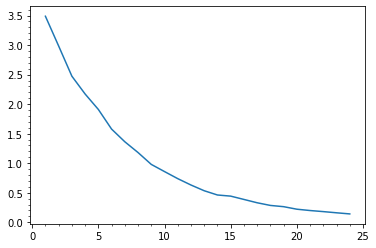

In [183]:
plt.plot(list(K),Sum_of_squared_distances)
plt.minorticks_on()

### Now let's look at the cluster

## Cluster 1

In [184]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Regent Park, Harbourfront",0,Coffee Shop,Breakfast Spot,Theater,Spa,Food Truck,Event Space,Electronics Store,Restaurant,Bakery,Italian Restaurant
1,"Queen's Park, Ontario Provincial Government",0,Coffee Shop,Sandwich Place,Gastropub,Theater,Burrito Place,Café,Falafel Restaurant,Fried Chicken Joint,Bank,Italian Restaurant
2,"Garden District, Ryerson",0,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Japanese Restaurant,Diner,Bubble Tea Shop,Bookstore,Ramen Restaurant,Fast Food Restaurant
3,St. James Town,0,Coffee Shop,Cocktail Bar,Clothing Store,Hotel,Gastropub,Restaurant,Café,Cosmetics Shop,Beer Bar,Lingerie Store
5,Berczy Park,0,Coffee Shop,Bakery,Beer Bar,Breakfast Spot,Restaurant,Cocktail Bar,Seafood Restaurant,Cheese Shop,Farmers Market,Yoga Studio
6,Central Bay Street,0,Coffee Shop,Clothing Store,Sandwich Place,Bubble Tea Shop,Café,Plaza,Restaurant,Sushi Restaurant,Cosmetics Shop,Bookstore
7,Christie,0,Café,Grocery Store,Playground,Baby Store,Candy Store,Italian Restaurant,Coffee Shop,Athletics & Sports,Escape Room,Ethiopian Restaurant
8,"Richmond, Adelaide, King",0,Coffee Shop,Hotel,Café,Restaurant,Gym,American Restaurant,Salad Place,Japanese Restaurant,Steakhouse,Asian Restaurant
9,"Dufferin, Dovercourt Village",0,Park,Grocery Store,Bakery,Pharmacy,Middle Eastern Restaurant,Smoke Shop,Café,Brazilian Restaurant,Furniture / Home Store,Bar
10,"Harbourfront East, Union Station, Toronto Islands",0,Coffee Shop,Hotel,Restaurant,Plaza,Japanese Restaurant,Aquarium,Deli / Bodega,Park,Boat or Ferry,Shopping Mall


#### In the first cluster we see a lot of Coffee Shop as the most common venue

## Cluster 2

In [189]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Lawrence Park,1,Bus Line,Swim School,Yoga Studio,Electronics Store,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant


#### In the second cluster we have Bus Line as the most common venye

In [190]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,"Forest Hill North & West, Forest Hill Road Park",2,French Restaurant,Park,Yoga Studio,Eastern European Restaurant,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant


#### In the 3rd cluster we have  French Restaurant as the most common venue

In [191]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == -1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Roselawn,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### In this cluster we have Roselawn that had no venues at all

In [188]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Central Toronto,4,Playground,Gym Pool,Park,Eastern European Restaurant,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
33,Downtown Toronto,4,Tennis Court,Playground,Park,Shop & Service,Bike Trail,Eastern European Restaurant,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm


### Here we have park as the 3rd most common venue and in the first two most common venues we have Playground 